
**Project Repository:** https://github.com/GokulKarthik/deep-learning-projects-pytorch

### References:
[1] https://github.com/carnotaur/crnn-tutorial/

In [449]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

import string
from tqdm.notebook import tqdm
import cv2
from PIL import Image, ImageChops
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import multiprocessing as mp

In [450]:
cpu_count = mp.cpu_count()
print(cpu_count)

16


## 1. Make train-test split

**Data Link**: https://www.kaggle.com/shawon10/captcha-recognition

In [451]:
data_path = "./output"

In [452]:
image_fns = os.listdir(data_path)
image_fns = [f"{i}.png" for i in range(len(image_fns))]
print(len(image_fns))
print(np.unique([len(image_fn.split(".")[0]) for image_fn in image_fns]))

10000
[1 2 3 4]


In [453]:
for idx, image_fn in enumerate(image_fns):
    if len(image_fn.split(".")[0]) != 5:
           print(idx, image_fn)

0 0.png
1 1.png
2 2.png
3 3.png
4 4.png
5 5.png
6 6.png
7 7.png
8 8.png
9 9.png
10 10.png
11 11.png
12 12.png
13 13.png
14 14.png
15 15.png
16 16.png
17 17.png
18 18.png
19 19.png
20 20.png
21 21.png
22 22.png
23 23.png
24 24.png
25 25.png
26 26.png
27 27.png
28 28.png
29 29.png
30 30.png
31 31.png
32 32.png
33 33.png
34 34.png
35 35.png
36 36.png
37 37.png
38 38.png
39 39.png
40 40.png
41 41.png
42 42.png
43 43.png
44 44.png
45 45.png
46 46.png
47 47.png
48 48.png
49 49.png
50 50.png
51 51.png
52 52.png
53 53.png
54 54.png
55 55.png
56 56.png
57 57.png
58 58.png
59 59.png
60 60.png
61 61.png
62 62.png
63 63.png
64 64.png
65 65.png
66 66.png
67 67.png
68 68.png
69 69.png
70 70.png
71 71.png
72 72.png
73 73.png
74 74.png
75 75.png
76 76.png
77 77.png
78 78.png
79 79.png
80 80.png
81 81.png
82 82.png
83 83.png
84 84.png
85 85.png
86 86.png
87 87.png
88 88.png
89 89.png
90 90.png
91 91.png
92 92.png
93 93.png
94 94.png
95 95.png
96 96.png
97 97.png
98 98.png
99 99.png
100 100.png
101 101.

In [454]:
# image_fns.remove('samples')
print(len(image_fns))

10000


In [455]:
label = pd.read_csv('./data2.csv')

In [456]:
label

,label
0,17955
1,230070
2,126332
3,915767
4,7760
...,...
9995,360173
9996,1284
9997,43927
9998,74741


In [457]:
data = train_test_split(image_fns, list(map(str, label['label'].to_numpy())), random_state=0)
image_fns_train, image_fns_test, label_train, label_test = data[0], data[1], data[2], data[3]
# data = train_test_split(image_fns, label['label'].to_numpy(), random_state=0)
# print(data)
print(len(image_fns_train), len(image_fns_test))

7500 2500


## 2. Define character maps

In [458]:
image_ns = [str(num) for num in label['label']]
image_ns = "".join(image_ns)
letters = sorted(list(set(list(image_ns))))
print(len(letters))
print(letters)

10
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [459]:
vocabulary = ["-"] + letters
print(len(vocabulary))
print(vocabulary)
idx2char = {k:v for k,v in enumerate(vocabulary, start=0)}
print(idx2char)
char2idx = {v:k for k,v in idx2char.items()}
print(char2idx)

11
['-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
{0: '-', 1: '0', 2: '1', 3: '2', 4: '3', 5: '4', 6: '5', 7: '6', 8: '7', 9: '8', 10: '9'}
{'-': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10}


## 3. Define data loader

In [460]:
batch_size = 64

In [467]:
class CAPTCHADataset(Dataset):
    
    def __init__(self, data_dir, image_fns, label):
        self.data_dir = data_dir
        self.image_fns = image_fns
        self.label = label
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.data_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        noise = Image.effect_noise((200, 50), 100).convert('RGB')
        image = ImageChops.multiply(image, noise)
        image = self.transform(image)
        text = self.label[index]
        return image, text
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [468]:
trainset = CAPTCHADataset(data_path, image_fns_train, label_train) 
testset = CAPTCHADataset(data_path, image_fns_test, label_test)
train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=0, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, num_workers=0, shuffle=False)
print(len(train_loader), len(test_loader))

118 40


In [469]:
image_batch, text_batch = iter(train_loader).next()
print(image_batch.size(), text_batch)

torch.Size([64, 3, 50, 200]) ('868660', '650210', '9702', '116363', '46845', '156550', '2038', '428959', '346483', '1457313', '972986', '1345200', '68821', '83822', '60770', '1323828', '6531', '3052', '1025531', '940684', '706046', '52054', '891195', '1474886', '37371', '34344', '29598', '394496', '193460', '663004', '16405', '72052', '1010388', '1283', '8305', '1314438', '986030', '33129', '151595', '11145', '290573', '22531', '20263', '303880', '107251', '252835', '1311', '472676', '9139', '973503', '1113661', '83563', '1304276', '198912', '801056', '743532', '13455', '107229', '56815', '717578', '545328', '1006149', '10454', '3035')


## 4. Define model

In [470]:
num_chars = len(char2idx)
print(num_chars)
rnn_hidden_size = 256

11


In [471]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [472]:
resnet = resnet18(pretrained=False)
#print(resnet)

In [473]:
class CRNN(nn.Module):
    
    def __init__(self, num_chars, rnn_hidden_size=256, dropout=0.1):
        
        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        # print(batch.size())# torch.Size([-1, 256, 4, 10])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 10, 256, 4])
         
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 10, 1024])
        
        batch = self.linear1(batch)
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 20])
        
        batch = batch.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([10, -1, 20])
        
        return batch

In [474]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [475]:
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [476]:
#crnn

In [477]:
text_batch_logits = crnn(image_batch.to(device))
print(text_batch)
print(text_batch_logits.shape)

('868660', '650210', '9702', '116363', '46845', '156550', '2038', '428959', '346483', '1457313', '972986', '1345200', '68821', '83822', '60770', '1323828', '6531', '3052', '1025531', '940684', '706046', '52054', '891195', '1474886', '37371', '34344', '29598', '394496', '193460', '663004', '16405', '72052', '1010388', '1283', '8305', '1314438', '986030', '33129', '151595', '11145', '290573', '22531', '20263', '303880', '107251', '252835', '1311', '472676', '9139', '973503', '1113661', '83563', '1304276', '198912', '801056', '743532', '13455', '107229', '56815', '717578', '545328', '1006149', '10454', '3035')
torch.Size([10, 64, 11])


## 5. Define loss

In [478]:
criterion = nn.CTCLoss(blank=0)

In [479]:
def encode_text_batch(text_batch):
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [480]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 
    #print(text_batch_logps.shape)
    #print(text_batch_logps_lens) 
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    #print(text_batch_targets)
    #print(text_batch_targets_lens)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

In [481]:
compute_loss(text_batch, text_batch_logits)

tensor(3.1755, device='cuda:0', grad_fn=<MeanBackward0>)

## 6. Train model

In [499]:
num_epochs = 50
lr = 0.0001
weight_decay = 1e-3
clip_norm = 5

In [500]:
optimizer = optim.Adam(crnn.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5)

In [501]:
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [502]:
epoch_losses = []
iteration_losses = []
num_updates_epochs = []
for epoch in tqdm(range(1, num_epochs+1)):
    epoch_loss_list = [] 
    num_updates_epoch = 0
    for image_batch, text_batch in tqdm(train_loader, leave=False):
        optimizer.zero_grad()
        text_batch_logits = crnn(image_batch.to(device))
        loss = compute_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()

        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue
          
        num_updates_epoch += 1
        iteration_losses.append(iteration_loss)
        epoch_loss_list.append(iteration_loss)
        loss.backward()
        nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
        optimizer.step()

    epoch_loss = np.mean(epoch_loss_list)
    print("Epoch:{}    Loss:{}    NumUpdates:{}".format(epoch, epoch_loss, num_updates_epoch))
    epoch_losses.append(epoch_loss)
    num_updates_epochs.append(num_updates_epoch)
    lr_scheduler.step(epoch_loss)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:1    Loss:1.2817853989123282    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:2    Loss:0.67128140439611    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:3    Loss:0.5556985309510343    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:4    Loss:0.49812388515421574    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:5    Loss:0.46096197463301963    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:6    Loss:0.43417835210177946    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:7    Loss:0.4131444108638682    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:8    Loss:0.3962679355383428    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:9    Loss:0.38281451029055663    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:10    Loss:0.37161075446143077    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:11    Loss:0.3622370805821693    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:12    Loss:0.3545311888906239    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:13    Loss:0.34788148654803536    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:14    Loss:0.34226716022247444    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:15    Loss:0.3373734756573431    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:16    Loss:0.3307163673423247    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:17    Loss:0.32963869267943574    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:18    Loss:0.3257065118630049    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:19    Loss:0.32227540753289324    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:20    Loss:0.3191703130949789    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:21    Loss:0.3162323169743837    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:22    Loss:0.31409982364696226    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:23    Loss:0.31181638695792097    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:24    Loss:0.3095863490724869    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:25    Loss:0.3080630554382735    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:26    Loss:0.3062014545141253    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:27    Loss:0.30589293493136666    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:28    Loss:0.3036098778883277    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:29    Loss:0.3011496877238186    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:30    Loss:0.2999450956771115    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:31    Loss:0.299196548235696    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:32    Loss:0.29782305734116893    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:33    Loss:0.2962639234594699    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:34    Loss:0.2952843049823094    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:35    Loss:0.29537069625945994    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:36    Loss:0.2926176430891826    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:37    Loss:0.29235480134802333    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:38    Loss:0.2904472769196354    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:39    Loss:0.2909704992321254    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:40    Loss:0.2892389383270288    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:41    Loss:0.2898299360453193    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:42    Loss:0.28845931059007707    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:43    Loss:0.2868523070298787    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:44    Loss:0.28682404318089677    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:45    Loss:0.28593734052898023    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:46    Loss:0.2856208295392583    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:47    Loss:0.28282308219465363    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:48    Loss:0.2847832641494808    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:49    Loss:0.2847782894810125    NumUpdates:469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:50    Loss:0.28386717717022275    NumUpdates:469


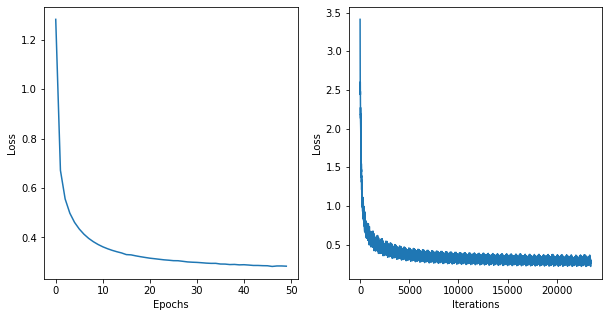

In [503]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epoch_losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(iteration_losses)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")

plt.show()

## 7. Make predictions

In [504]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [505]:
results_train = pd.DataFrame(columns=['actual', 'prediction'])
train_loader = DataLoader(trainset, batch_size=16, num_workers=0, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(train_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_train = pd.concat([results_train, df])
results_train = results_train.reset_index(drop=True)

  0%|          | 0/469 [00:00<?, ?it/s]

In [506]:
results_test = pd.DataFrame(columns=['actual', 'prediction'])
test_loader = DataLoader(testset, batch_size=16, num_workers=0, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(test_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_test = pd.concat([results_test, df])
results_test = results_test.reset_index(drop=True)

  0%|          | 0/157 [00:00<?, ?it/s]

In [507]:
print(results_train.shape)
results_train.head()

(7500, 2)


,actual,prediction
0,1314438,13114-4438
1,289257,2889922557
2,1231,1122233311
3,129214,1229922114
4,236213,2336622113


In [508]:
print(results_test.shape)
results_test.head()

(2500, 2)


,actual,prediction
0,1220897,12-2008997
1,7525,7755522255
2,93774,99337--744
3,1238,1122333388
4,2307,2233300077


In [509]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [510]:
results_train['prediction_corrected'] = results_train['prediction'].apply(correct_prediction)
results_train.head()

,actual,prediction,prediction_corrected
0,1314438,13114-4438,1314438
1,289257,2889922557,289257
2,1231,1122233311,1231
3,129214,1229922114,129214
4,236213,2336622113,236213


In [511]:
results_test['prediction_corrected'] = results_test['prediction'].apply(correct_prediction)
results_test.head()

,actual,prediction,prediction_corrected
0,1220897,12-2008997,1220897
1,7525,7755522255,7525
2,93774,99337--744,93774
3,1238,1122333388,1238
4,2307,2233300077,2307


## 8. Evaluate the model

In [512]:
mistakes_df = results_test[results_test['actual'] != results_test['prediction_corrected']]
mistakes_df

,actual,prediction,prediction_corrected
114,1316867,1311666667,13167
208,122243,12----2443,12243
277,1271211,12271111-1,12711
278,1011882,1011118882,10182
349,111155,1-1-1115-5,11155
409,1185884,1-1888-884,11884
490,1188290,1-18822990,118290
543,1118696,1-1-166996,111696
614,1117949,1-1-199449,111949
616,911378,9111133778,91378


In [513]:
print(mistakes_df['prediction_corrected'].str.len().value_counts())

5    18
6    17
4     1
Name: prediction_corrected, dtype: int64


In [514]:
mask = mistakes_df['prediction_corrected'].str.len() >= 0
mistakes_df[mask]

,actual,prediction,prediction_corrected
114,1316867,1311666667,13167
208,122243,12----2443,12243
277,1271211,12271111-1,12711
278,1011882,1011118882,10182
349,111155,1-1-1115-5,11155
409,1185884,1-1888-884,11884
490,1188290,1-18822990,118290
543,1118696,1-1-166996,111696
614,1117949,1-1-199449,111949
616,911378,9111133778,91378


In [515]:
# mistake_image_fp = os.path.join(data_path, mistakes_df[mask]['actual'].values[0] + ".png")
# print(mistake_image_fp)
# mistake_image = Image.open(mistake_image_fp)
# plt.imshow(mistake_image)
# plt.show()

In [516]:
train_accuracy = accuracy_score(results_train['actual'], results_train['prediction_corrected'])
print(train_accuracy)
test_accuracy = accuracy_score(results_test['actual'], results_test['prediction_corrected'])
print(test_accuracy)

0.9950666666666667
0.9856
